In [1]:
!pip install shap > shap.log
!pip install kapre > kapre.log

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
directory = '/content/drive/MyDrive/Curruira'
!cp /content/drive/MyDrive/Curruira/models.py .
!ls

Mounted at /content/drive
drive  kapre.log  models.py  sample_data  shap.log


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import models
import tensorflow as tf
from tensorflow.keras import layers
import shap
import cv2
import librosa
import random
import os

tf.compat.v1.disable_eager_execution()
directory = "."

In [7]:
# Open the pickled file in binary mode and read the pickled data
with open(os.path.join(directory,'labels.pkl'), 'rb') as f:
    labels = pickle.load(f) # A eh amostra impactada e B nao impactada

with open(os.path.join(directory,'wav_records.pkl'), 'rb') as f:
    wav_records = pickle.load(f)

## Embeddings extraction with Biophony + Kapre

In [5]:
!mkdir biophony_model
!mkdir ./biophony_model/resources/
!cp /content/drive/MyDrive/Curruira/biophony_model/resources/cmi_mbam01.json ./biophony_model/resources/cmi_mbam01.json
!cp /content/drive/MyDrive/Curruira/biophony_model/resources/cmi_mbam01.h5 ./biophony_model/resources/cmi_mbam01.h5

In [8]:
kapre_model = models.build_kapre_model()
biophony_model = models.build_biophony_model()
model = models.build_model(kapre_model, biophony_model)
model.summary()

2024-08-20 19:10:15.374306: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_5_1/bias/Assign' id:1398 op device:{requested: '', assigned: ''} def:{{{node dense_5_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_5_1/bias, dense_5_1/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 40, 682, 1)        3         
                                                                 
 sequential_6 (Sequential)   (None, 512)               3547456   
                                                                 
 drop1 (Dropout)             (None, 512)               0         
                                                                 
 den1 (Dense)                (None, 512)               262656    
                                                                 
 drop2 (Dropout)             (None, 512)               0         
                                                                 
 den2 (Dense)                (None, 2)                 1026      
                                                                 
Total params: 3811141 (14.54 MB)
Trainable params: 381

In [9]:
checkpoint_filepath = os.path.join(directory,'kfold_model_SHAP.h5')
model.load_weights(checkpoint_filepath)

2024-08-20 19:10:23.569607: W tensorflow/c/c_api.cc:305] Operation '{name:'den1_2/bias/Assign' id:1730 op device:{requested: '', assigned: ''} def:{{{node den1_2/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](den1_2/bias, den1_2/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [10]:
spec_model = models.spectrogram_model(model, summary=True)
shap_model = models.shap_model(model)
shap_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 44100, 1)          3         
 tion)                                                           
                                                                 
 gaussian_noise_1 (Gaussian  (None, 44100, 1)          0         
 Noise)                                                          
                                                                 
 stft_1 (STFT)               (None, 682, 257, 1)       0         
                                                                 
 magnitude_1 (Magnitude)     (None, 682, 257, 1)       0         
                                                                 
Total params: 3 (16.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________
Model: "sequential_9"


In [11]:
# reshape to batches for the input model.
X_train = wav_records.reshape(wav_records.shape[0], wav_records.shape[1], 1)

# converting lables to categorical
labels = 1*(labels=='amostraA') # A eh amostra impactada e B nao impactada

# select a set of background examples to take an expectation over
spectrograms = spec_model.predict(X_train) # em caso de estouro de memoria e kernel morrendo usar menos amostras, ex: X_train[0:50]

with open(os.path.join(directory,'spectrograms.pkl'), 'wb') as f:
    pickle.dump(np.asarray(spectrograms), f)

/home/ufamlas/.local/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [12]:
biophony_predictions = shap_model.predict(spectrograms)

with open(os.path.join(directory,'biophony_predictions.pkl'), 'wb') as f:
    pickle.dump(np.asarray(biophony_predictions), f)

2024-08-20 19:10:32.807485: W tensorflow/c/c_api.cc:305] Operation '{name:'activation_1/Softmax' id:2085 op device:{requested: '', assigned: ''} def:{{{node activation_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](den2_3/Softmax)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


## Local explainer

In [13]:
# select a set of background examples to take an expectation over
samples = spectrograms[np.random.choice(spectrograms.shape[0], 300, replace=False)]
e = shap.DeepExplainer(shap_model, samples)

/home/ufamlas/.local/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


<Figure size 2500x1500 with 0 Axes>

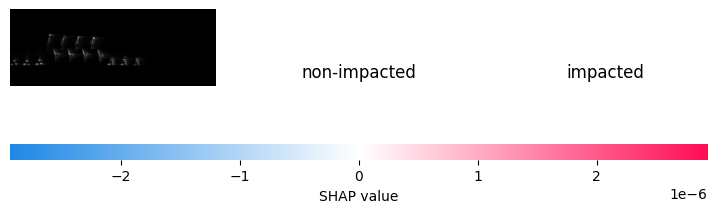

<Figure size 2500x1500 with 0 Axes>

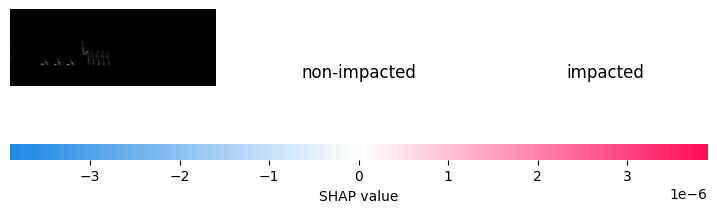

In [14]:
shap_values = e.shap_values(spectrograms[0:2], check_additivity=False)

for i in range(len(shap_values)):
    img = spectrograms[i:i+1]
    # plot the feature attributions
    plt.figure(figsize=(25,15))
    shap.image_plot([np.flip(shap_values[0][i:i+1].T,1), np.flip(shap_values[1][i:i+1].T,1)],
                    np.flip(img.T,1), width=80, aspect = 0.2, labels=['non-impacted', 'impacted'], hspace=0)
    plt.show()

## Global explainer

In [15]:
shap_values = e.shap_values(spectrograms, check_additivity=False)
print('done')

done


In [16]:
# Open a file in binary mode and write the pickled list to it
with open(os.path.join(directory,'shap_values.pkl'), 'wb') as f:
    pickle.dump(shap_values, f)
print('done')

done
